## Прогноз количества заказов такси на следующий час

<a href='#section1'>1. Подготовка</a>

<a href='#section2'>2. Анализ</a>

<a href='#section3'>3. Обучение</a>

<a href='#section4'>4. Тестирование</a>

<a href='#section5'>Вывод</a>

<a id='section1'></a>
### 1. Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col = ['datetime'], parse_dates=['datetime'])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
# проверим в хронологическом ли порядке идут записи
df.index.is_monotonic 

True

In [4]:
df = df.resample('1H').sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


В файле с данными более 25 тысяч строк. После ресемплирования с 10 минут до часа количество записей уменьшилось в 6 раз.
<a id='section2'></a>
### 2. Анализ

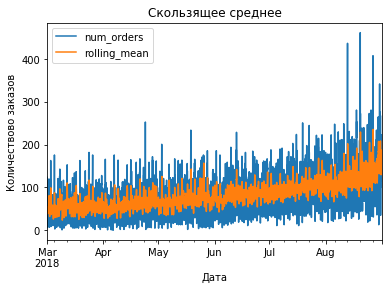

In [5]:
df['rolling_mean'] = df.rolling(8).mean()
df.plot()
plt.title('Скользящее среднее')
plt.xlabel('Дата')
plt.ylabel('Количествово заказов')
plt.show()

In [6]:
df = df.drop(['rolling_mean'], axis = 1)

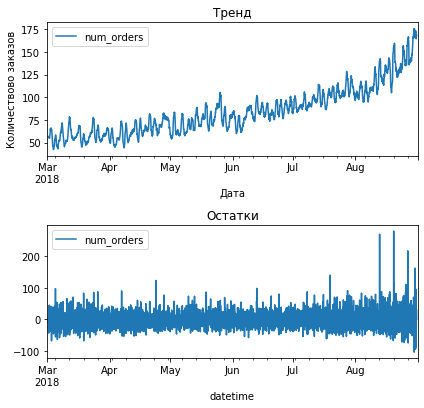

In [7]:
decomposed = seasonal_decompose(df)
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), figsize=(6, 8))
plt.xlabel('Дата')
plt.ylabel('Количествово заказов')
plt.title('Тренд')
plt.subplot(312)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')
plt.tight_layout()
plt.show()

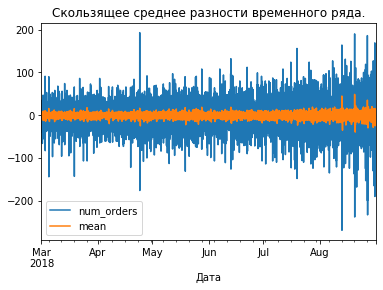

In [8]:
sh = df - df.shift()
sh['mean'] = sh.rolling(8).mean()
sh.plot()
plt.xlabel('Дата')
plt.title('Скользящее среднее разности временного ряда.')
plt.show()

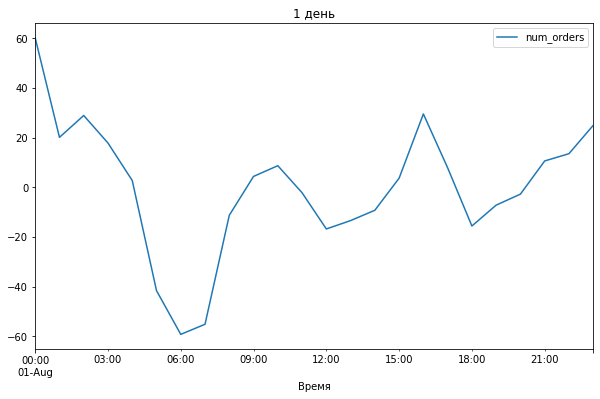

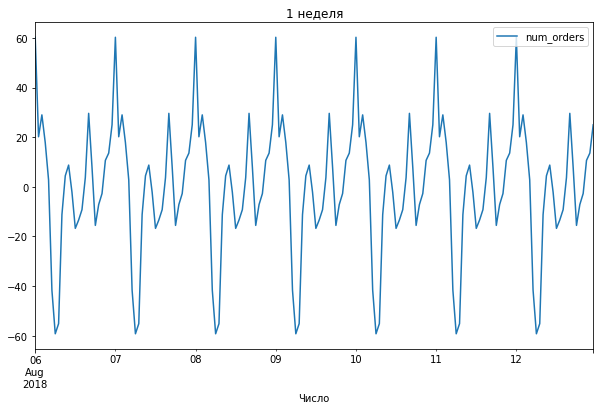

In [23]:
decomposed.seasonal['2018-08-01':'2018-08-01'].plot(ax=plt.gca(), figsize=(10, 6))
plt.title('1 день')
plt.xlabel('Время')
plt.show()
decomposed.seasonal['2018-08-06':'2018-08-12'].plot(ax=plt.gca(), figsize=(10, 6))
plt.title('1 неделя')
plt.xlabel('Число')
plt.show()

<div class="alert alert-info">
Добавила графики сезонности за день и неделю. Каких-то отличий по количеству заказов в выходные не наблюдается, а в течении дня меньше всего заказов рано утром, а больше всего с 11 вечера до двух ночи, днём в 16 - 17 часов тоже много. 
</div>
Построили графики скользящего среднего, этот ряд нестационарный. Тренд представляет собой нестационарный ряд, количество заказов растёт, думаю за счёт роста самой службы такси, а не сезонность.

График остатков и скользящее среднее разности временного ряда более менее похожи на стационарные временные ряды.

<a id='section3'></a>
### 3. Обучение

In [27]:
# функция для создания признаков
def make_features(df, max_lag, rolling_mean_size):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(df, 1, 24)
df.tail()

,num_orders,hour,dayofweek,lag_1,rolling_mean
datetime,,,,,
2018-08-31 19:00:00,136,19,4,207.0,164.875000
2018-08-31 20:00:00,154,20,4,136.0,167.541667
2018-08-31 21:00:00,159,21,4,154.0,168.041667
2018-08-31 22:00:00,223,22,4,159.0,166.416667
2018-08-31 23:00:00,205,23,4,223.0,169.125000


In [10]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
print('Размеры полученных наборов:')
print('тренировочный - ', train.shape[0])
print('тестовый - ', test.shape[0])
print('тестовый - ', df.shape[0])
print()
print('Диапазоны выборок по времени:')
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())
print()
print("Средний объём заказов в час:", int(test['num_orders'].mean()))

train = train.dropna()
# Отделение целевого признака от остальных
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

train.head()

Размеры полученных наборов:
тренировочный -  3974
тестовый -  442
тестовый -  4416

Диапазоны выборок по времени:
2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00

Средний объём заказов в час: 139


,num_orders,hour,dayofweek,lag_1,rolling_mean
datetime,,,,,
2018-03-01 08:00:00,34,8,3,15.0,52.750
2018-03-01 09:00:00,69,9,3,34.0,41.500
2018-03-01 10:00:00,64,10,3,69.0,39.500
2018-03-01 11:00:00,96,11,3,64.0,38.625
2018-03-01 12:00:00,30,12,3,96.0,42.375


In [11]:
%%time
estimator = CatBoostRegressor(random_state=12345, verbose = 0)
params_grid = {
    'depth': [4, 6, 10],
    'learning_rate': [0.02, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'iterations': [100, 200, 500]
}
split_index = TimeSeriesSplit().split(features_train)

gbm = GridSearchCV(estimator, params_grid, scoring = 'neg_mean_squared_error', n_jobs = -1,
                   cv = split_index)
gbm.fit(features_train, target_train)

CPU times: user 18min 56s, sys: 3min 6s, total: 22min 2s
Wall time: 28min 20s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f8805db7b50>,
             error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostRegressor object at 0x7f8805c0e110>,
             iid='warn', n_jobs=-1,
             param_grid={'depth': [4, 6, 10], 'iterations': [100, 200, 500],
                         'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.02, 0.05, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [12]:
print('Лучшие параметры для модели CatBoostRegressor:')
print(gbm.best_params_)
print()
model = LinearRegression()
model.fit(features_train, target_train)
model_bust = CatBoostRegressor(random_state=12345,
                               verbose=0,
                              depth = 4,
                              iterations = 500,
                              l2_leaf_reg = 1,
                              learning_rate = 0.1)
model_bust.fit(features_train, target_train)

Лучшие параметры для модели CatBoostRegressor:
{'depth': 4, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.05}



Создали признаки для обучения моделей: день недели, час, lag - влияние предыдущего отрезка времени на настоящий, rolling_mean - скользящее среднее. 

Разделили данные на обучающую и тестовую выборки. Удалили NaN из тренировочной выборки.

Для модели CatBoostRegressor подобрали лучшие параметры с помощью GridSearchCV.

Обучили модели линейной регрессии и CatBoostRegressor.
<a id='section4'></a>
### 4. Тестирование

In [13]:
predictions = model.predict(features_test)
print('RMSE линейной регрессии - ', int(mean_squared_error(predictions, target_test)**0.5))
predictions = model_bust.predict(features_test)
print('RMSE модели CatBoostRegressor - ', int(mean_squared_error(predictions, target_test)**0.5))

RMSE линейной регрессии -  54
RMSE модели CatBoostRegressor -  42


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 2 columns):
Ответы          442 non-null int64
Предсказания    442 non-null float64
dtypes: float64(1), int64(1)
memory usage: 30.4 KB


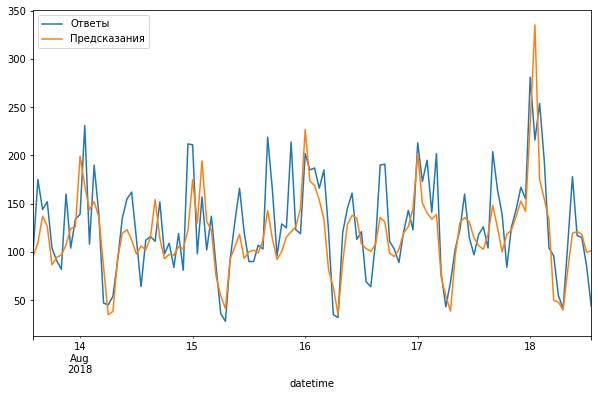

In [37]:
pl = pd.DataFrame({'Ответы':target_test, 'Предсказания':predictions}) 
pl.info()
pl.head(120).plot(figsize=(10, 6))

Тестирование моделей показало, что значение метрики RMSE соответствует условию только у модели CatBoostRegressor.

<a id='section5'></a>
### Вывод
Получено итоговое значение метрики RMSE - 42, этого удалось достичь используя модель градиентного бустинга CatBoostRegressor. Также применили линеную регрессию, но в результате получили значение RMSE более 48.

Набор данных разделили в соотношении 9:1 на обучающую и тестовую выборки. Обучающие признаки создали.

С помощью GridSearchCV подобрали лучшие параметры для модели CatBoostRegressor. Только подобранные параметры оказались не лучшими и я подобрала вручную некоторые из них, возможно из-за того, что в тестовой выборке другие данные.